In [1]:
import numpy as np
import community
import networkx as nx
import os
import pickle
from data_load import load_data
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
path_thickness = path + 'FreeSurfer/thickness/'
thinkness = []
idx_subj_think = []

for foldername in sorted(os.listdir(path_thickness)):
    if foldername in idx_subj_connec:
    idx_subj_think += [foldername]
    tmp = []
    with open(path_thickness + foldername + '/' + 'LH_thick_smooth_2e-4.raw', 'rb') as f:
            t = np.fromfile(f, count=-1 ,dtype='float32')
            t = np.where(t < 0, 0, t)
            tmp += [t]
    with open(path_thickness + foldername + '/' + 'RH_thick_smooth_2e-4.raw', 'rb') as f:
            t = np.fromfile(f, count=-1 ,dtype='float32')
            t = np.where(t < 0, 0, t)
            tmp += [t]
    thinkness += [tmp]

In [13]:
np.array(thinkness).shape

(816, 2, 163842)

In [18]:
np.where(thinkness[0][0] == 0)[0]

array([   144,    315,    355, ..., 163293, 163294, 163297])

In [2]:
path = '/home/bgutman/datasets/HCP/''FreeSurfer/thickness/'
connec, think, idx = load_data(path)

connectomes:  (793, 2, 68, 68)
thinkness:  (793, 2, 163842)


In [152]:
idx[245]

'168139'

In [140]:
with open(path + 'LH_labels_MajVote.raw', 'rb') as f:
    LH = np.fromfile(f, count=-1 ,dtype='float32')
with open(path + 'RH_labels_MajVote.raw', 'rb') as f:
    RH = np.fromfile(f, count=-1 ,dtype='float32')

In [144]:
min(LH), max(LH), max(RH), min(RH)

(0.0, 35.0, 70.0, 0.0)

(array([ 12632.,      0.,      0.,      0.,      0.,   9642.,  35639.,
         18898.,  41636.,  45395.]),
 array([  0.,   7.,  14.,  21.,  28.,  35.,  42.,  49.,  56.,  63.,  70.]),
 <a list of 10 Patch objects>)

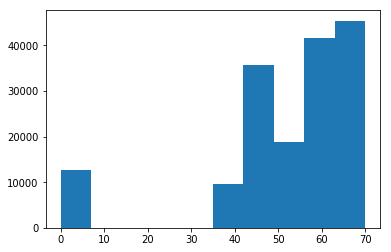

In [151]:
plt.hist(RH)

In [108]:
hist_  = [len(np.where(squareform(connec[i,0,:,:])>0.)[0])/(68*67)*2 for i in range(len(think))]

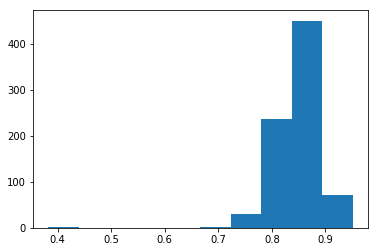

In [110]:
plt.hist(hist_);

In [120]:
bin_connec = connec[:,0,:,:].copy()
bin_connec[connec[:,0,:,:] > 0] = 1 

In [139]:
len(np.where(squareform(bin_connec.sum(axis = 0)/len(bin_connec)) ==1.)[0])/68/67*2

0.23529411764705885

In [112]:
np.where(np.array(hist_)< 0.5)[0]

array([245])

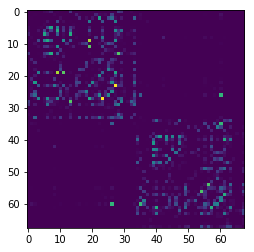

In [114]:
plt.imshow(connec[245,0,:,:]);

In [115]:
mean_con = connec.sum(axis = 0)/len(connec)

In [118]:
len(np.where(mean_con[0] > 0)[0])/68/67

1.0

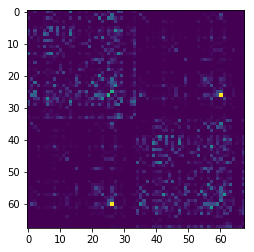

In [116]:
plt.imshow(mean_con[0])

In [3]:
idx[491]

'361941'

In [92]:
think.shape

(793, 2, 163842)

In [98]:
len(np.where(think[0,1,:] < 0.)[0])/163842

0.007397370637565459

In [91]:
connec.shape

(793, 2, 68, 68)

In [16]:
partitions = []
for FULL, NORMED in connec:
    GF = nx.from_numpy_array(FULL)
    GN = nx.from_numpy_array(NORMED)
    partF = community.best_partition(GF)
    partN = community.best_partition(GN)
    partitions += [np.array([np.array(list(partF.values())), np.array(list(partN.values()))])]

In [17]:
partitions = np.array(partitions)
print(partitions.shape)

(793, 2, 68)


In [18]:
partF, partN = partitions[:, 0, :], partitions[:, 1, :]

In [19]:
np.allclose(partF, partN)

True

In [21]:
partitions = partitions[:, 0, :] 

In [22]:
with open('partition_HCP.pkl', 'wb') as f:
    pickle.dump(partitions, f)

In [27]:
modularity = []
for i, one_subj in enumerate(connec):
    G = nx.from_numpy_array(one_subj[0])
    part = {j: partitions[i][j] for j in range(68)} 
    mod_score = community.modularity(part, G, weight='weight')
    modularity += [mod_score]

In [28]:
modularity = np.array(modularity)
modularity.shape

(793,)

In [29]:
with open('modularity_score_HCP.pkl', 'wb') as f:
    pickle.dump(modularity, f)

In [30]:
with open('connectomes_HCP.pkl', 'wb') as f:
    pickle.dump(connec, f)

In [6]:
inverted_connec_div = []
for FULL, NORMED in connec:
    invF = np.where(FULL!= 0, 1./FULL, 0.)
    invN = np.where(NORMED!= 0, 1./NORMED, 0.)
    inverted_connec_div += [np.array([invF, invN])]

/home/ayagoz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ayagoz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [7]:
inverted_connec_div = np.array(inverted_connec_div)
inverted_connec_div.shape

(793, 2, 68, 68)

In [111]:
with open('connectomes_inv_div_HCP.pkl', 'wb') as f:
    pickle.dump(inverted_connec_div, f)

In [8]:
inverted_connec_sub = []
for FULL, NORMED in connec:
    maxF, maxN = max(squareform(FULL)), max(squareform(NORMED))
    invF = np.where(FULL != 0, maxF + 1 - FULL, 0.)
    invN = np.where(NORMED != 0, maxN + 1e-21 - NORMED, 0.)
    inverted_connec_sub += [np.array([invF, invN])]

In [9]:
inverted_connec_sub = np.array(inverted_connec_sub)
inverted_connec_sub.shape

(793, 2, 68, 68)

In [114]:
with open('connectomes_inv_sub_HCP.pkl', 'wb') as f:
    pickle.dump(inverted_connec_div, f)

In [115]:
path_div = []
for FULL, NORMED in inverted_connec_div:
    GF = nx.from_numpy_array(FULL)
    GN = nx.from_numpy_array(NORMED)
    pF = np.mean([np.sum(list(one[1].values()))/67 for one in list(nx.shortest_path_length(GF, weight='weight'))])
    pN = np.mean([np.sum(list(one[1].values()))/67 for one in list(nx.shortest_path_length(GN, weight='weight'))])
    
    path_div += [np.array([pF, pN])]

In [116]:
path_div = np.array(path_div)
print(path_div.shape)

(793, 2)


In [124]:
with open('path_inv_div_HCP.pkl', 'wb') as f:
    pickle.dump(path_div, f)

In [120]:
path_sub = []
for FULL, NORMED in inverted_connec_sub:
    GF = nx.from_numpy_array(FULL)
    GN = nx.from_numpy_array(NORMED)
    pF = np.mean([np.sum(list(one[1].values()))/67 for one in list(nx.shortest_path_length(GF, weight='weight'))])
    pN = np.mean([np.sum(list(one[1].values()))/67 for one in list(nx.shortest_path_length(GN, weight='weight'))])
    
    path_sub += [np.array([pF, pN])]

In [121]:
path_sub = np.array(path_sub)
print(path_sub.shape)

(793, 2)


In [123]:
with open('path_inv_sub_HCP.pkl', 'wb') as f:
    pickle.dump(path_sub, f)

In [10]:
radius_div = []
for i, (FULL, NORMED) in enumerate(inverted_connec_div):
    GF = nx.from_numpy_array(FULL)
    GN = nx.from_numpy_array(NORMED)
    try:
        rF = nx.radius(GF)
        rN = nx.radius(GN)
    except:
        print(i)
        rF = 0
        rN = 0
    
    radius_div += [np.array([rF, rN])]

491


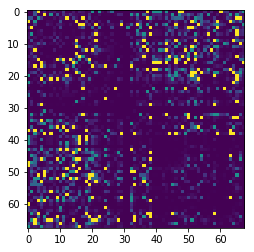

In [11]:
plt.imshow(inverted_connec_div[491][0])

In [12]:
G1 = nx.from_numpy_array(inverted_connec_div[491][1])
G2 = nx.from_numpy_array(inverted_connec_div[491][0])

In [13]:
nx.is_connected(G1), nx.is_connected(G2)

(False, False)

In [14]:
nx.is_connected(nx.from_numpy_array(connec[491, 1, :, :]))

False

In [17]:
np.array([len(one) for one in nx.connected_components(nx.from_numpy_array(connec[491, 1, :, :]))])

array([67,  1])

In [18]:
radius_div = np.array(radius_div)
print(radius_div.shape)

(793, 2)


In [19]:
if np.allclose(radius_div[:,0], radius_div[:,1]):
    radius_div = radius_div[:,0]

True

In [21]:
with open('radius_inv_div_HCP.pkl', 'wb') as f:
    pickle.dump(radius_div, f)

In [22]:
radius_sub = []
for i, (FULL, NORMED) in enumerate(inverted_connec_sub):
    GF = nx.from_numpy_array(FULL)
    GN = nx.from_numpy_array(NORMED)
    try:
        rF = nx.radius(GF)
        rN = nx.radius(GN)
    except:
        print(i)
        rF = 0
        rN = 0
    
    radius_sub += [np.array([rF, rN])]

491


In [23]:
radius_sub = np.array(radius_sub)
print(radius_sub.shape)

(793, 2)


In [24]:
np.allclose(radius_sub[:,0], radius_sub[:,1])

False

In [25]:
if np.allclose(radius_sub[:,0], radius_sub[:,1]):
    radius_sub = radius_sub[:,0]

In [26]:
radius_sub.shape

(793, 2)

In [27]:
with open('radius_inv_sub_HCP.pkl', 'wb') as f:
    pickle.dump(radius_sub, f)

In [83]:
radius_div = radius_div.reshape(-1,1)

In [84]:
np.concatenate([radius_div, radius_sub],axis = -1)

array([[2, 2, 2],
       [1, 1, 1],
       [1, 1, 1],
       ..., 
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2]])

In [86]:
def av_deg_transform(dic_res, num = 68):
    d = {i: 0 for i in range(num)}
    for i, v in dic_res.items():
        d[i] = v
    return d

In [ ]:
def calsululs(metric_name, matrix, num = 68):
    assert len(matrix.shape) == 3, 'Non correct format of data, should be [n_sample, num , num], where num is a number of nodes in Graph'
    
    flag = False
    if 'average_degree_connectivity' in metric_name:
        flag = True
        
    if type(metric_name) == str:
        func = getattr(nx, metric_name)
    elif len(metric_name) > 1:
        funcs = [getattr(nx, one) for one in metric_name]
        else:
            func = getattr(nx, metric_name[0])
        
    data = []
    
    for one_sub in matrix:
        t = 
        
        

In [88]:
func = getattr(nx, 'average_degree_connectivity')

In [76]:
nx.average_clustering(nx.from_numpy_array(connec[0,0,:,:]), weight='weight')

0.013356957858875031

In [74]:
nx.load_centrality(nx.from_numpy_array(connec[0,0,:,:]), weight='weight')

{0: 0.04196307423919363,
 1: 0.0,
 2: 0.060238624697579936,
 3: 0.00134554500226142,
 4: 0.0918659318845886,
 5: 0.026804070376831555,
 6: 0.059762523960285155,
 7: 0.0045958249876160324,
 8: 0.012340444243429319,
 9: 0.011178572325960385,
 10: 0.051863158952711194,
 11: 0.027924931618961472,
 12: 0.0011872455902306649,
 13: 0.020266686050268136,
 14: 0.11154482368101767,
 15: 0.027958254662234755,
 16: 0.039842409525245356,
 17: 0.10083989324660964,
 18: 0.03842188767561902,
 19: 0.0,
 20: 0.004422198172198172,
 21: 0.00692352032526162,
 22: 0.0,
 23: 0.0,
 24: 0.0034928442204561604,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0039028343132820743,
 29: 0.026867819392695017,
 30: 0.022746167251764267,
 31: 0.05805710205585828,
 32: 0.0656026146324654,
 33: 0.003133529682037144,
 34: 0.009698351675963616,
 35: 0.009492520562172304,
 36: 0.016861422505079215,
 37: 0.04269094642228971,
 38: 0.0017714458012965473,
 39: 0.0,
 40: 0.03254143244814887,
 41: 0.0013847010737558,
 42: 0.0,
 43: 0.01124

In [70]:
nx.communicability_betweenness_centrality(nx.from_numpy_array(connec[0,0,:,:]))

{0: 0.3795922242478174,
 1: 0.6546864891140763,
 2: 0.5144009040515235,
 3: 0.5271050298091327,
 4: 0.35832865868527825,
 5: 0.602373655342538,
 6: 0.6351392594364673,
 7: 0.6042648862977295,
 8: 0.6367183551597182,
 9: 0.6240081819831608,
 10: 0.5310887405443996,
 11: 0.6364096317736058,
 12: 0.6135210155845365,
 13: 0.6135634676197095,
 14: 0.4916987252815866,
 15: 0.6459354198939055,
 16: 0.527537351031619,
 17: 0.39247452471969435,
 18: 0.461571613022972,
 19: 0.6158868296519056,
 20: 0.646401779579073,
 21: 0.6353509292170436,
 22: 0.6468896960873293,
 23: 0.6546864891140769,
 24: 0.6446208226890797,
 25: 0.6546864891140769,
 26: 0.6546864891140768,
 27: 0.6546864891140769,
 28: 0.6240302941107871,
 29: 0.6439975057894295,
 30: 0.6337051022273638,
 31: 0.56750190029119,
 32: 0.5675231104116367,
 33: 0.6468896960873293,
 34: 0.5151640790149724,
 35: 0.6283293495381675,
 36: 0.6253667941651045,
 37: 0.5970593450334016,
 38: 0.05418841731048982,
 39: 0.6213274259703186,
 40: 0.652865

In [68]:
nx.current_flow_closeness_centrality(nx.from_numpy_array(connec[0,0,:,:]), weight='weight')

{0: 83.3193633816142,
 1: 105.94451413164833,
 2: 103.57638080881932,
 3: 100.21404374582947,
 4: 53.356487810100155,
 5: 110.61853036969723,
 6: 112.70658958059,
 7: 111.21534820193033,
 8: 86.15711678009251,
 9: 103.81216230200964,
 10: 101.96900630745745,
 11: 106.69601135536101,
 12: 104.32820057117007,
 13: 111.09157296875405,
 14: 77.98172005056777,
 15: 99.4019703947784,
 16: 105.9769192729086,
 17: 79.40842539362303,
 18: 101.33251934832249,
 19: 108.50989148343623,
 20: 108.86437093495314,
 21: 98.3190539384929,
 22: 112.75489560284677,
 23: 113.76805191713314,
 24: 105.18237826310369,
 25: 116.84920091341007,
 26: 117.8453632857888,
 27: 117.77753876854024,
 28: 113.88611949061006,
 29: 114.88598242745739,
 30: 96.1023234019778,
 31: 89.76786935317071,
 32: 97.33694951135799,
 33: 114.62843341776275,
 34: 101.1439978671124,
 35: 107.57670668542914,
 36: 110.06866045489922,
 37: 109.87992490769908,
 38: 2.9257130993424747,
 39: 111.28470910815444,
 40: 116.95143107168833,
 41:

In [67]:
nx.current_flow_betweenness_centrality(nx.from_numpy_array(connec[0,0,:,:]),weight='weight')
#effective resistance
#information centrality

{0: 0.006786234621266706,
 1: 0.027703720083520053,
 2: 0.021127673537748116,
 3: 0.02136456206732063,
 4: 0.006396530799687274,
 5: 0.05816779880185215,
 6: 0.05291468620254213,
 7: 0.050050298919716914,
 8: 0.015071189705973277,
 9: 0.03043630146754736,
 10: 0.02791008859424159,
 11: 0.03854460900557801,
 12: 0.03936766062097414,
 13: 0.046863115163414376,
 14: 0.015048567110120072,
 15: 0.019135272307020505,
 16: 0.028097568994253887,
 17: 0.009457303874627147,
 18: 0.022871529898663104,
 19: 0.039943393263754644,
 20: 0.036030261981321594,
 21: 0.018403035298430643,
 22: 0.05668625497913827,
 23: 0.06349643023233854,
 24: 0.03444653808373581,
 25: 0.0984414607891734,
 26: 0.10688839955371697,
 27: 0.1048114710466796,
 28: 0.06417441785719145,
 29: 0.06632369182198307,
 30: 0.02119990221385325,
 31: 0.016763425267518655,
 32: 0.015289961481981633,
 33: 0.07284208749752198,
 34: 0.02794796836303202,
 35: 0.029958707833570693,
 36: 0.03978535550440817,
 37: 0.03222708261057578,
 38: 0

In [61]:
nx.communicability(nx.from_numpy_array(connec[0,0,:,:]))

{0: {0: 4.8868017203225245e+23,
  1: 7.238933062174372e+23,
  2: 5.993868145064748e+23,
  3: 6.103521115126213e+23,
  4: 4.7150194710491576e+23,
  5: 6.755408158122832e+23,
  6: 7.054679854604842e+23,
  7: 6.772915183506519e+23,
  8: 7.070052664282372e+23,
  9: 6.95168700491611e+23,
  10: 6.136108435531331e+23,
  11: 7.067082464957122e+23,
  12: 6.855842742029663e+23,
  13: 6.856077955406629e+23,
  14: 5.8054830943656255e+23,
  15: 7.156211416806005e+23,
  16: 6.104667718324973e+23,
  17: 4.992643285111406e+23,
  18: 5.556942139615041e+23,
  19: 6.878200196897686e+23,
  20: 7.16081128452761e+23,
  21: 7.056879221022343e+23,
  22: 7.165671590662369e+23,
  23: 7.238933062174348e+23,
  24: 7.14331413579435e+23,
  25: 7.238933062174348e+23,
  26: 7.238933062174348e+23,
  27: 7.238933062174348e+23,
  28: 6.95169688178663e+23,
  29: 7.137368568245816e+23,
  30: 7.041011740685434e+23,
  31: 6.447404836343976e+23,
  32: 6.447701036583536e+23,
  33: 7.16567159066237e+23,
  34: 5.995168713900727

In [60]:
nx.betweenness_centrality(nx.from_numpy_array(connec[0,0,:,:]), weight = 'weight')

{0: 0.04518803725045245,
 1: 0.0,
 2: 0.06316976322729642,
 3: 0.0011118649178350672,
 4: 0.09303540509442813,
 5: 0.027387453116761128,
 6: 0.06568445427326156,
 7: 0.005183380743082235,
 8: 0.012071591950605974,
 9: 0.010885195280730972,
 10: 0.05362020983778506,
 11: 0.028783473227030832,
 12: 0.0010659186032320358,
 13: 0.023405005871018056,
 14: 0.11598803561716269,
 15: 0.03177545210096358,
 16: 0.04059241928984128,
 17: 0.10294179830588697,
 18: 0.03743947519388496,
 19: 0.0,
 20: 0.0051210372631342645,
 21: 0.008913876016863753,
 22: 0.0,
 23: 0.0,
 24: 0.003206122863517707,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.004074863776356314,
 29: 0.028766814473973865,
 30: 0.024565858283633047,
 31: 0.05864492309539799,
 32: 0.0702132068142923,
 33: 0.0028874274125291768,
 34: 0.009317589541470137,
 35: 0.009245096829900086,
 36: 0.016314204498284097,
 37: 0.04440864678313796,
 38: 0.0015151515151515152,
 39: 0.0,
 40: 0.032486399390515175,
 41: 0.0015047141912813554,
 42: 0.0,
 43: 0.012

In [59]:
nx.closeness_centrality(nx.from_numpy_array(connec[0,0,:,:]), distance='weight')

{0: 0.3004484304932735,
 1: 0.2518796992481203,
 2: 0.32682926829268294,
 3: 0.24187725631768953,
 4: 0.2925764192139738,
 5: 0.3004484304932735,
 6: 0.3471502590673575,
 7: 0.29004329004329005,
 8: 0.27800829875518673,
 9: 0.26907630522088355,
 10: 0.2757201646090535,
 11: 0.3004484304932735,
 12: 0.23344947735191637,
 13: 0.32057416267942584,
 14: 0.33668341708542715,
 15: 0.3316831683168317,
 16: 0.3004484304932735,
 17: 0.3160377358490566,
 18: 0.29646017699115046,
 19: 0.2701612903225806,
 20: 0.2925764192139738,
 21: 0.29385964912280704,
 22: 0.20059880239520958,
 23: 0.16584158415841585,
 24: 0.26693227091633465,
 25: 0.24452554744525548,
 26: 0.07173447537473233,
 27: 0.16381418092909536,
 28: 0.2863247863247863,
 29: 0.3116279069767442,
 30: 0.29130434782608694,
 31: 0.29910714285714285,
 32: 0.3316831683168317,
 33: 0.2637795275590551,
 34: 0.2768595041322314,
 35: 0.24014336917562723,
 36: 0.3004484304932735,
 37: 0.29777777777777775,
 38: 0.1976401179941003,
 39: 0.23263888

In [57]:
nx.degree_centrality(nx.from_numpy_array(connec[0,0,:,:]))

{0: 0.6417910447761194,
 1: 0.9701492537313433,
 2: 0.7910447761194029,
 3: 0.7910447761194029,
 4: 0.6119402985074627,
 5: 0.8955223880597015,
 6: 0.9402985074626865,
 7: 0.8955223880597015,
 8: 0.9402985074626865,
 9: 0.9253731343283582,
 10: 0.8059701492537313,
 11: 0.9402985074626865,
 12: 0.9104477611940298,
 13: 0.9104477611940298,
 14: 0.7611940298507462,
 15: 0.9552238805970149,
 16: 0.8059701492537313,
 17: 0.6567164179104478,
 18: 0.7313432835820896,
 19: 0.9104477611940298,
 20: 0.9552238805970149,
 21: 0.9402985074626865,
 22: 0.9552238805970149,
 23: 0.9701492537313433,
 24: 0.9552238805970149,
 25: 0.9701492537313433,
 26: 0.9701492537313433,
 27: 0.9701492537313433,
 28: 0.9253731343283582,
 29: 0.9552238805970149,
 30: 0.9402985074626865,
 31: 0.8507462686567164,
 32: 0.8507462686567164,
 33: 0.9552238805970149,
 34: 0.7910447761194029,
 35: 0.9402985074626865,
 36: 0.9253731343283582,
 37: 0.8805970149253731,
 38: 0.22388059701492538,
 39: 0.9402985074626865,
 40: 0.98

In [58]:
nx.eigenvector_centrality(nx.from_numpy_array(connec[0,0,:,:]), weight = 'weight')

{0: 0.017237173396375587,
 1: 0.08827662703999317,
 2: 0.058979812092016616,
 3: 0.05327760721676398,
 4: 0.0035316930107418786,
 5: 0.06380287792066294,
 6: 0.09097504327785523,
 7: 0.07519530831989538,
 8: 0.0289539148378603,
 9: 0.041491027607533135,
 10: 0.03305303029525072,
 11: 0.05062050475979571,
 12: 0.04816693178555925,
 13: 0.07459218003118646,
 14: 0.011204489665317887,
 15: 0.060191828457394785,
 16: 0.05623343139819039,
 17: 0.01205473141599155,
 18: 0.03700221662381793,
 19: 0.06712692515961229,
 20: 0.08242268370233793,
 21: 0.054697095444945346,
 22: 0.11170472752682706,
 23: 0.1370174101026239,
 24: 0.06698576416398312,
 25: 0.15051035715249234,
 26: 0.22009841577861966,
 27: 0.1847825780629647,
 28: 0.09860103979869259,
 29: 0.12209986627500097,
 30: 0.0346965303772066,
 31: 0.019654715823895472,
 32: 0.03343959742279803,
 33: 0.10102687419081331,
 34: 0.03801418509566788,
 35: 0.10860082335743969,
 36: 0.10400624594959625,
 37: 0.12825264316065804,
 38: 0.0002430229

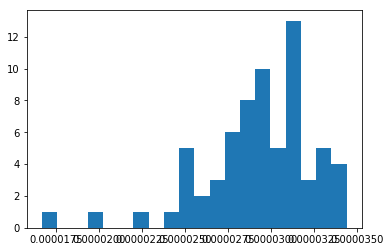

In [34]:
plt.hist(list(nx.closeness_centrality(GF, distance='weight').values()), bins = 20);

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class OrigN(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.func = 0

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X
    
    
class OrigS(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.func = 0

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X
